# Turtle Trading

Turtle trading is a project set up by commodity traders Richard Dennis and William Eckhardt in 1983 to prove that anyone can be taught to trade by following simple rules. The project was successful, with many of the traders making consistent returns by following the rules and becoming successful fund managers after the project concluded.

In this notebook, I backtest the results of the turtle trading rules and analyse the reasons for their success.

The turtle trading rules are:
1. Enter a position when prices crosses 20-day high.
2. Exit when prices fall below 10-day low or a trailing stop loss set at 2 x 20-day ATR.

There are other rules with regards to position sizing, risk management, pyramiding (adding to trades), etc. However, I ignored these since I want to see primarily how the entry and exit rules perform. In a similar vein, the commission fees, bid-ask spread, and other frictional costs are neglected.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from utils import misc
import datetime as dt
from trade_obj import *
from simple_backtester import backTester

# Use SPDR Gold Trust $GLD for backtesting to represent commodity trading
ticker = 'GLD'
df = pd.read_csv('datasets/stock_price_series/' + ticker + '.csv')
df = misc.clean_df(df)
df = df.set_index('date')

Generate indicators for entry and exit

In [2]:
df['20_up_bound'] = df['high'].shift(1).rolling(20).max()
df['20_low_bound'] = df['low'].shift(1).rolling(20).min()
df['10_up_bound'] = df['high'].shift(1).rolling(10).max()
df['10_low_bound'] = df['low'].shift(1).rolling(10).min()

df['High-Low'] = df['high'] - df['low']
df['High-PrevClose'] = abs(df['high'] - df['close'].shift(1))
df['Low-PrevClose'] = abs(df['low'] - df['close'].shift(1))
df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
df['ATR'] = df['TR'].rolling(20).mean()

df = df.dropna()
# df = df[-1000:]

Run backtest in simple customer framework

In [3]:
bt = backTester()
bt.set_asset(df)

# convert to np array to save time
upbound20 = df['20_up_bound'].to_numpy()
lowbound20 = df['20_low_bound'].to_numpy()
upbound10 = df['10_up_bound'].to_numpy()
lowbound10 = df['10_low_bound'].to_numpy()
atr = df['ATR'].to_numpy()

stop_loss_arr = []
stop_loss = np.nan

tl = tradeList()
last_trade_win = False
open_trade = None



for i in range(len(bt.df)):
    
    order_quantity = 0
    order_price = 0
    n = atr[i]
    

    # no open trades
    if open_trade == None:
        # breakout from 20 day high
        if bt.high[i] > upbound20[i]:

            long_entry_price = upbound20[i]
            # calculate stop_loss
            stop_loss = long_entry_price - 2 * n
                            
            # order price at breakout
            order_price = max(long_entry_price, bt.low[i])
            # order 1 unit
            order_quantity = bt.cash // long_entry_price
            
            # open trade on record
            open_trade = trade(bt.date[i], order_price, order_quantity, type='long20')
          

    # open trades present 
    else:
        # if open trades are long
        if open_trade.quantity > 0:
            pass
            # calculate trailing stop_loss
            stop_loss = max(stop_loss, bt.high[i] - 2 * n)
            # combine low bound 10 and trailing stop loss
            stop_loss = max(stop_loss, lowbound10[i])
            
            # exit trade if stop loss is triggered
            if bt.low[i] < stop_loss:

                # print(f'--- index {i}, date: {bt.date[i]} ---')
                # print(f'low: {bt.low[i]} < stop_loss: {stop_loss}')
                # exit price at stoploss
                order_price = min(stop_loss, bt.high[i])
                order_quantity = -open_trade.quantity
                    
                open_trade.close(bt.date[i], order_price)
                tl.append(open_trade)
                
                open_trade = None
                stop_loss = np.nan
    
        
    stop_loss_arr.append(stop_loss)

    bt.take_action(order_quantity=order_quantity, order_price=order_price)
            
# record stoplosses and entry prices for plotting
df['stop_loss'] = stop_loss_arr
df['entry_price'] = np.nan
df['exit_price'] = np.nan
df['entry_price'] = np.nan
df['exit_price'] = np.nan

for t in tl.list:
    for i in range(len(t.entry_date)):
        df.loc[df.index == t.entry_date[i], 'entry_price'] = t.entry_price[i]
        
    df.loc[df.index == t.exit_date, 'exit_price'] = t.exit_price



### Portfolio Stats

This section looks at the stats of a portfolio that runs this trade at no leverage.

This portfolio has lower returns and lower volatility/drawdowns compared to a buy-hold strategy. The portfolio manages to avoid the large drawdown events, thus preserving capital.

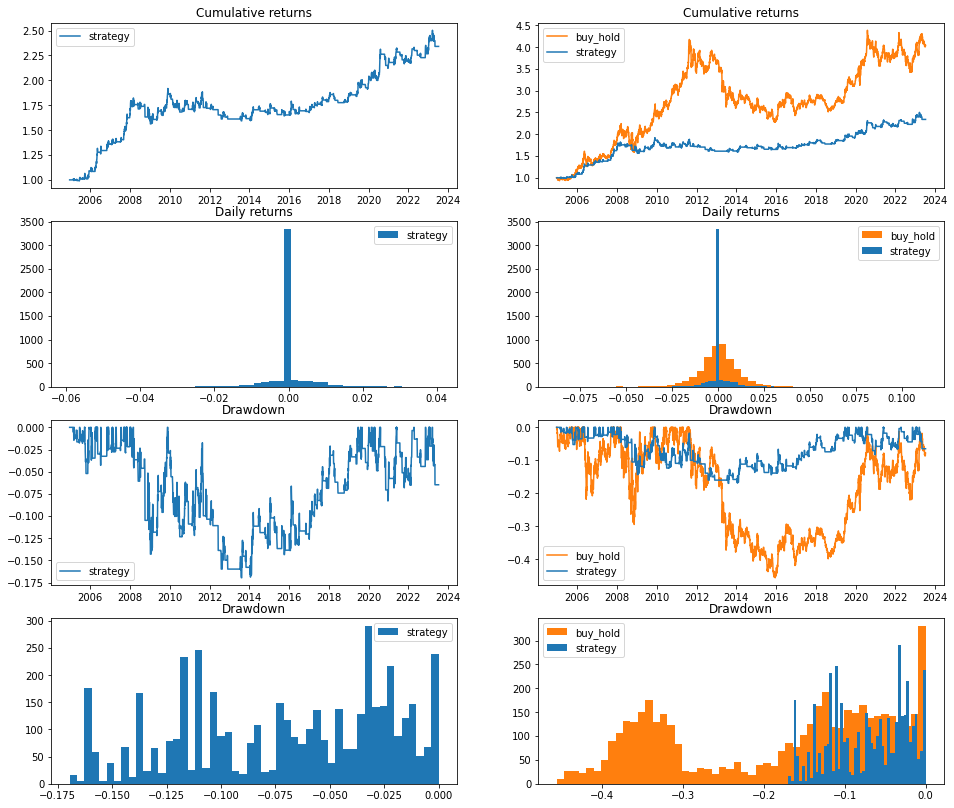

In [4]:
bt.analyse()
bt.plot_graphs()

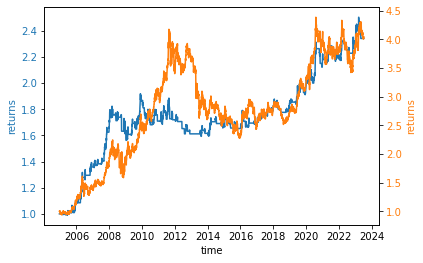

In [5]:
fig, ax1 = plt.subplots()

color = 'C0'
ax1.set_xlabel('time')
ax1.set_ylabel('returns', color=color)
ax1.plot(bt.date, bt.records['cum_returns'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'C1'
ax2 = ax1.twinx()
ax2.set_ylabel('returns', color=color)
ax2.plot(bt.date, bt.records['buy_hold_cum_returns'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_facecolor('xkcd:white')
plt.show()

In [6]:
print(f'Annualised return:          {bt.annual_return}')
print(f'buy_hold annual return:     {bt.buy_hold_annual_return}')
print('---------')
print(f'Annualised vol:             {bt.annual_vol}')
print(f'buy_hold annual vol:        {bt.buy_hold_annual_vol}')
print('---------')
print(f'Sharpe ratio:               {bt.sharpe}')
print(f'buy_hold Sharpe ratio:      {bt.buy_hold_sharpe}')

Annualised return:          0.06878038956728161
buy_hold annual return:     0.11551209420606323
---------
Annualised vol:             0.08725591073088536
buy_hold annual vol:        0.1777891605076308
---------
Sharpe ratio:               0.7882605200169654
buy_hold Sharpe ratio:      0.6497139301195215


### Trade record stats

This section looks at the backtest results on a trade-by-trade basis.

In [7]:
tl.analyse(bt.df)
tl.stats

{'num_wins': 78,
 'num_loss': 81,
 'win_rate': 0.49056603773584906,
 'profit_total': 1340783.3526615123,
 'profit_mean': 8432.599702273663,
 'returns_mean': 0.005763968241161654,
 'returns_std': 0.028875765157858817,
 'time_in_trade_mean': 12.232704402515724,
 'time_in_trade_std': 8.89829664296748,
 'capital_at_risk_mean': 1740774.8434180734,
 'win_returns_mean': 0.027681203167700723,
 'win_returns_std': 0.024653365726281077,
 'win_profit_mean': 46089.95923046208,
 'win_time_in_trade_mean': 16.897435897435898,
 'win_time_in_trade_std': 9.889768743885057,
 'loss_returns_mean': -0.015341517243653735,
 'loss_returns_std': 0.011933667199198491,
 'loss_profit_mean': -27830.04280635223,
 'loss_time_in_trade_mean': 7.7407407407407405,
 'loss_time_in_trade_std': 4.538110228326813}

We plot every single trade to view the characteristics of each trade.

trade 0
entry: [43.20000076293945]
cost_basis: 43.20000076293945
exit: 42.943001937866214
returns: -0.0059490467716314084


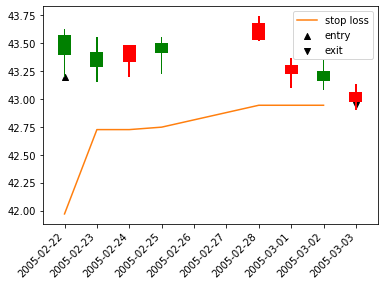

trade 1
entry: [43.7400016784668]
cost_basis: 43.7400016784668
exit: 43.8989990234375
returns: 0.0036350557583305874


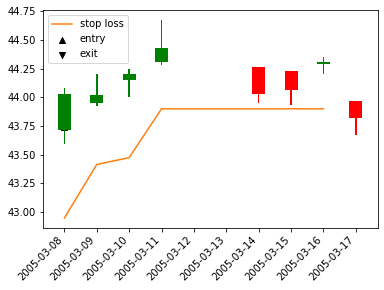

trade 2
entry: [43.25]
cost_basis: 43.25
exit: 43.05400009155273
returns: -0.004531789790688321


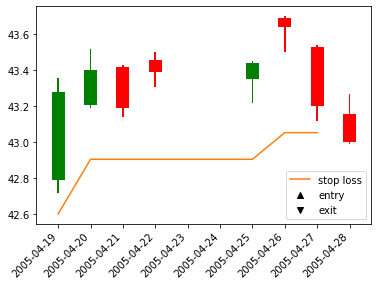

trade 3
entry: [42.650001525878906]
cost_basis: 42.650001525878906
exit: 43.36000061035156
returns: 0.016647105722653897


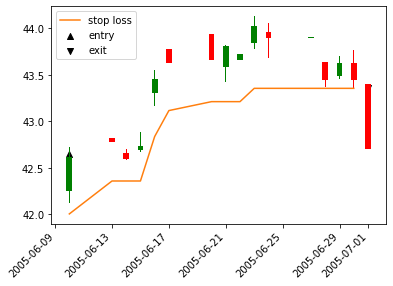

trade 4
entry: [43.34999847412109]
cost_basis: 43.34999847412109
exit: 43.22200012207031
returns: -0.0029526725849179924


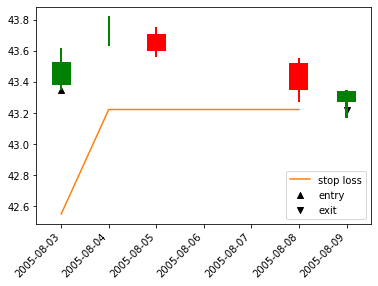

trade 5
entry: [43.86000061035156]
cost_basis: 43.86000061035156
exit: 44.10900230407715
returns: 0.0056771931203945525


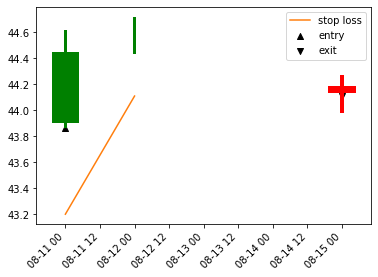

trade 6
entry: [44.720001220703125]
cost_basis: 44.720001220703125
exit: 46.18700065612793
returns: 0.03280410097005221


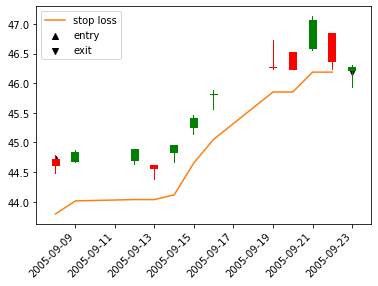

trade 7
entry: [47.130001068115234]
cost_basis: 47.130001068115234
exit: 46.16100044250488
returns: -0.020560165577121363


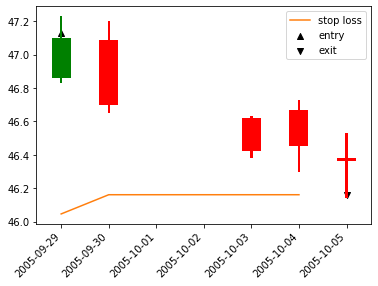

trade 8
entry: [47.22999954223633]
cost_basis: 47.22999954223633
exit: 46.5760009765625
returns: -0.01384710082601166


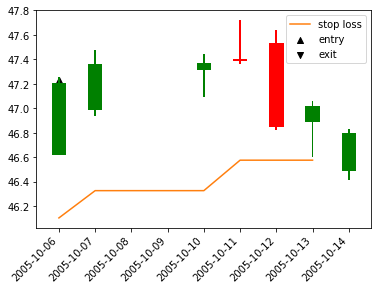

trade 9
entry: [47.41999816894531]
cost_basis: 47.41999816894531
exit: 48.26499938964844
returns: 0.017819511879620956


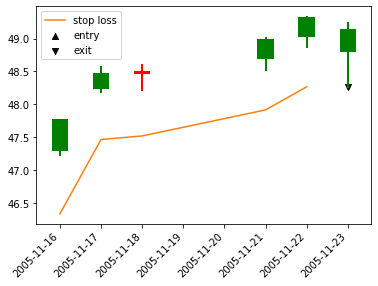

trade 10
entry: [49.34000015258789]
cost_basis: 49.34000015258789
exit: 52.31699714660645
returns: 0.06033637991106516


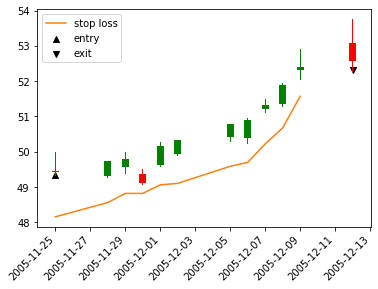

trade 11
entry: [53.7599983215332]
cost_basis: 53.7599983215332
exit: 54.037997817993165
returns: 0.005171121747386877


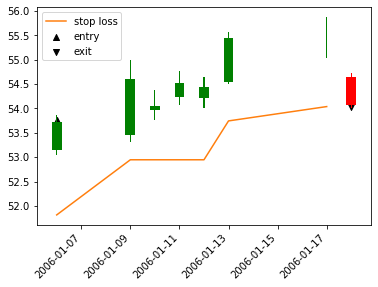

trade 12
entry: [55.869998931884766]
cost_basis: 55.869998931884766
exit: 55.32999954223633
returns: -0.009665283693790456


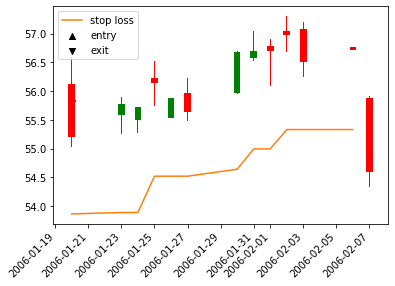

trade 13
entry: [56.81999969482422]
cost_basis: 56.81999969482422
exit: 62.015000915527345
returns: 0.09142909624436944


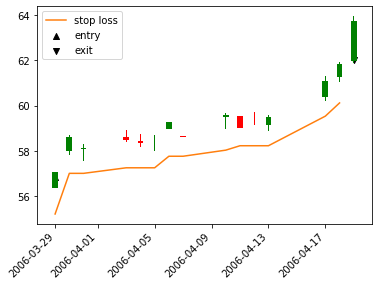

trade 14
entry: [63.95000076293945]
cost_basis: 63.95000076293945
exit: 68.98300132751464
returns: 0.07870211891368628


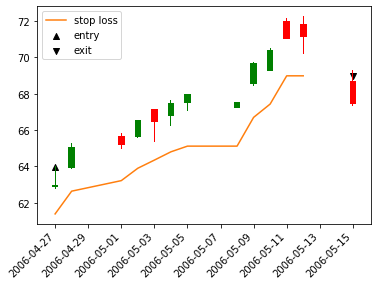

trade 15
entry: [62.84999847412109]
cost_basis: 62.84999847412108
exit: 63.702998352050784
returns: 0.013571995205074398


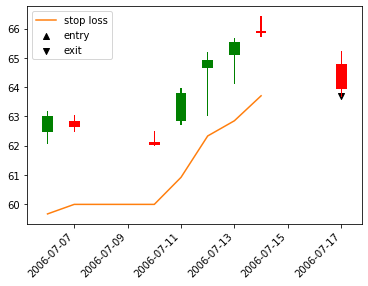

trade 16
entry: [59.880001068115234]
cost_basis: 59.880001068115234
exit: 62.8280029296875
returns: 0.049231827137391465


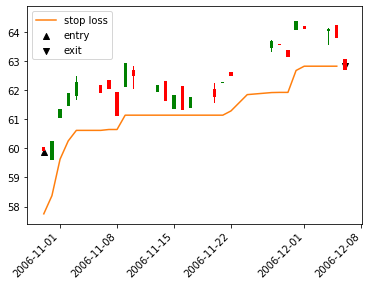

trade 17
entry: [64.0199966430664]
cost_basis: 64.0199966430664
exit: 65.85599784851074
returns: 0.028678558289852375


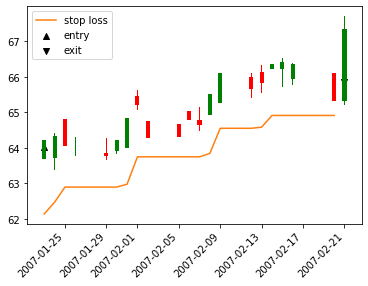

trade 18
entry: [67.70999908447266]
cost_basis: 67.70999908447266
exit: 66.39200210571289
returns: -0.01946532264925123


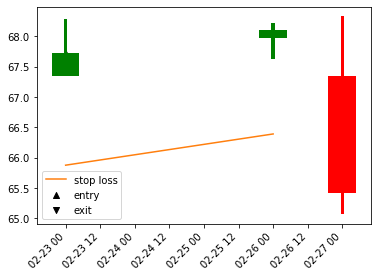

trade 19
entry: [66.4800033569336]
cost_basis: 66.4800033569336
exit: 67.08400115966796
returns: 0.009085405719543707


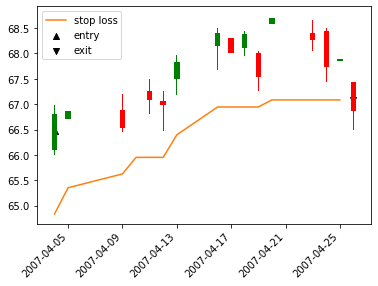

trade 20
entry: [65.55999755859375]
cost_basis: 65.55999755859375
exit: 66.59699821472168
returns: 0.015817582287142678


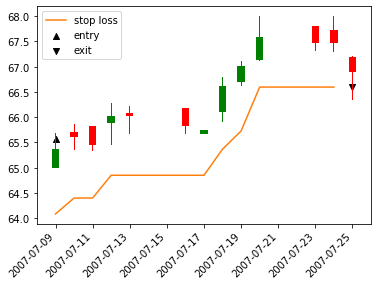

trade 21
entry: [67.54000091552734]
cost_basis: 67.54000091552734
exit: 71.83600234985352
returns: 0.06360677192911508


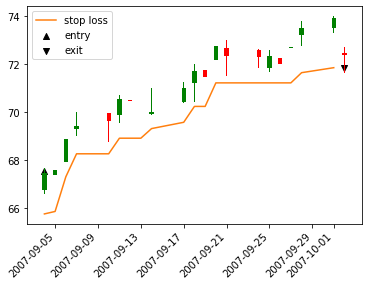

trade 22
entry: [73.9800033569336]
cost_basis: 73.9800033569336
exit: 80.44000244140625
returns: 0.08732088120224732


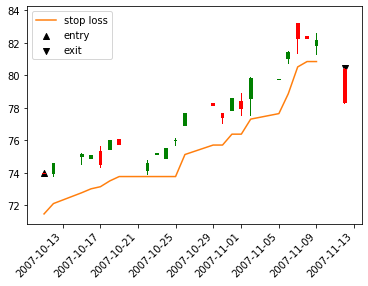

trade 23
entry: [81.0]
cost_basis: 81.0
exit: 87.67300033569336
returns: 0.08238272019374518


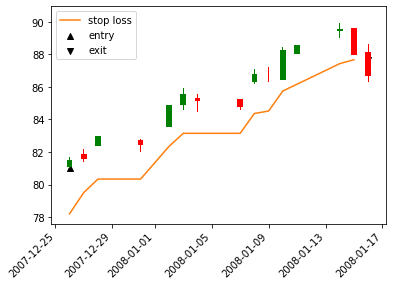

trade 24
entry: [90.3499984741211]
cost_basis: 90.3499984741211
exit: 89.19100112915038
returns: -0.012827862363524949


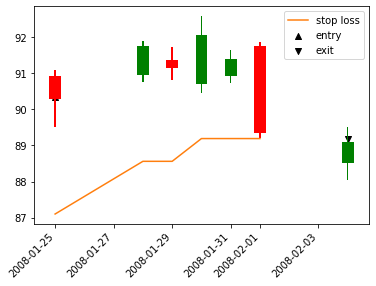

trade 25
entry: [92.58000183105467]
cost_basis: 92.58000183105467
exit: 94.605997467041
returns: 0.021883728622985852


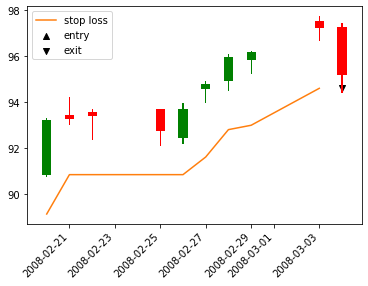

trade 26
entry: [97.73999786376952]
cost_basis: 97.73999786376952
exit: 96.79000244140624
returns: -0.009719617793396937


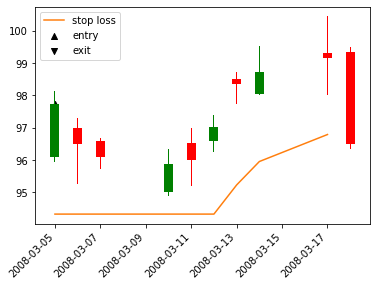

trade 27
entry: [91.16999816894533]
cost_basis: 91.16999816894533
exit: 88.88399887084961
returns: -0.025074030317074014


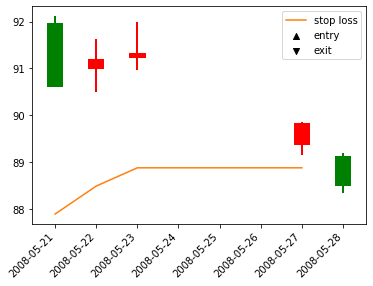

trade 28
entry: [89.61000061035156]
cost_basis: 89.61000061035156
exit: 90.02199935913086
returns: 0.004597687155151114


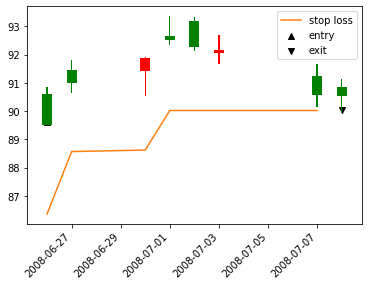

trade 29
entry: [93.3499984741211]
cost_basis: 93.3499984741211
exit: 94.3619987487793
returns: 0.010840924383504487


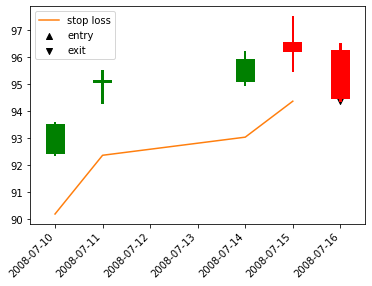

trade 30
entry: [84.54000091552734]
cost_basis: 84.54000091552734
exit: 85.4639991760254
returns: 0.010929716707967803


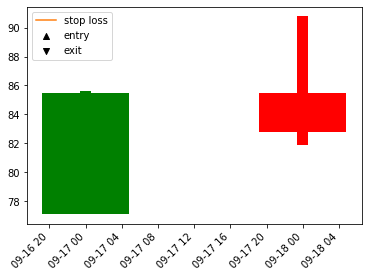

trade 31
entry: [90.77999877929688]
cost_basis: 90.77999877929688
exit: 84.27199935913086
returns: -0.07168979409206842


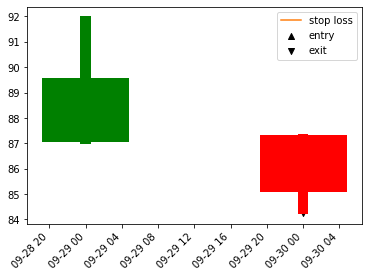

trade 32
entry: [76.36000061035156]
cost_basis: 76.36000061035156
exit: 76.48899765014649
returns: 0.0016893273803541267


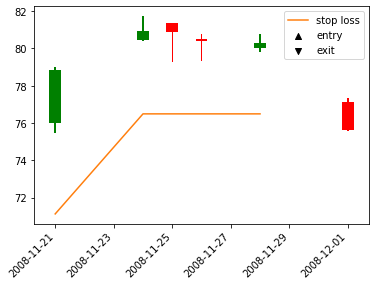

trade 33
entry: [81.72000122070312]
cost_basis: 81.72000122070312
exit: 81.87700424194335
returns: 0.0019212312640109603


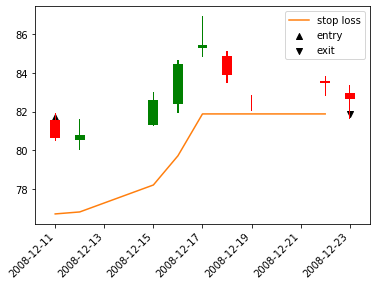

trade 34
entry: [86.91000366210938]
cost_basis: 86.91000366210938
exit: 82.90999832153321
returns: -0.04602468268356626


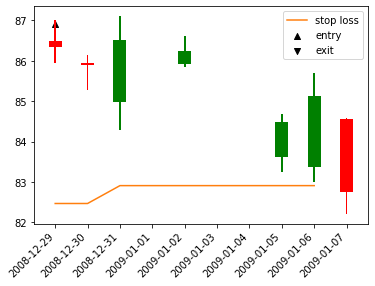

trade 35
entry: [87.0999984741211]
cost_basis: 87.0999984741211
exit: 87.86300354003905
returns: 0.008760104239779678


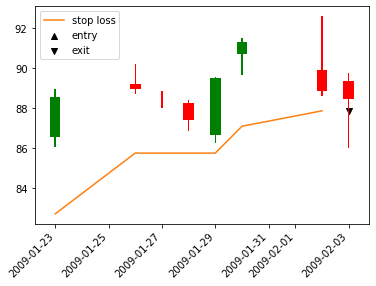

trade 36
entry: [92.58000183105467]
cost_basis: 92.58000183105467
exit: 94.42999801635742
returns: 0.019982676050047207


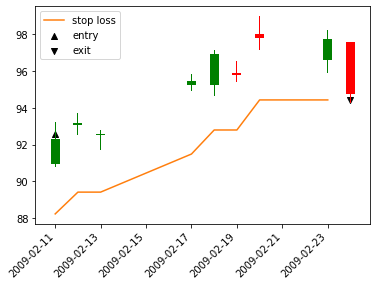

trade 37
entry: [89.83999633789062]
cost_basis: 89.83999633789062
exit: 94.51899948120118
returns: 0.05208151529428715


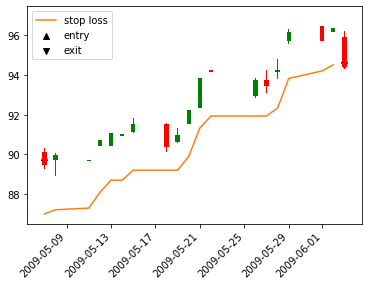

trade 38
entry: [93.0]
cost_basis: 93.0
exit: 91.74799804687501
returns: -0.013462386592741812


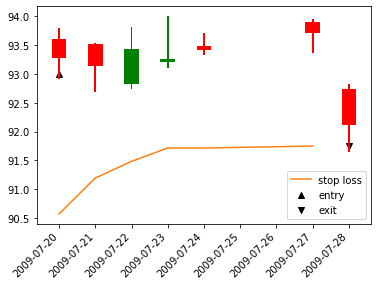

trade 39
entry: [94.0]
cost_basis: 94.0
exit: 92.86300430297851
returns: -0.012095698904483936


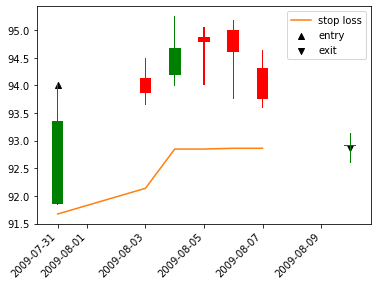

trade 40
entry: [95.19000244140624]
cost_basis: 95.19000244140624
exit: 97.50500030517577
returns: 0.024319758424153


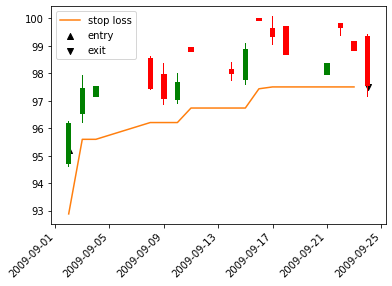

trade 41
entry: [100.54000091552734]
cost_basis: 100.54000091552734
exit: 102.52999877929688
returns: 0.019793095739490858


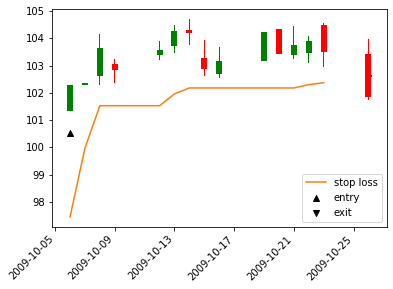

trade 42
entry: [104.6999969482422]
cost_basis: 104.6999969482422
exit: 113.807999420166
returns: 0.08699143015664348


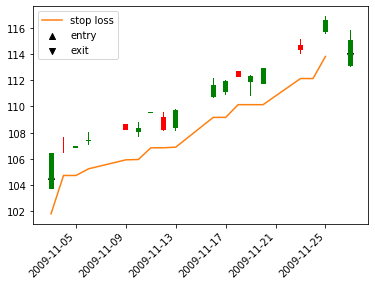

trade 43
entry: [116.87999725341795]
cost_basis: 116.87999725341795
exit: 116.29600143432617
returns: -0.0049965420329842174


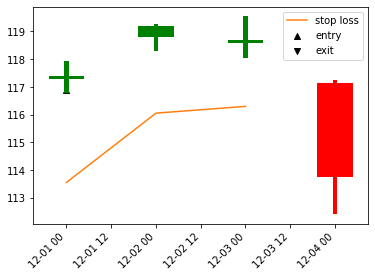

trade 44
entry: [112.5199966430664]
cost_basis: 112.5199966430664
exit: 109.4520034790039
returns: -0.027266203835703304


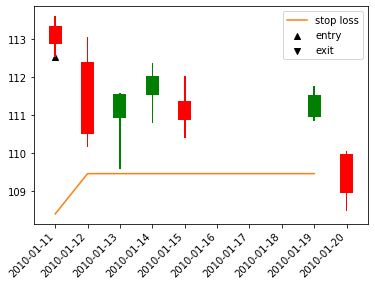

trade 45
entry: [110.0500030517578]
cost_basis: 110.0500030517578
exit: 106.70999908447266
returns: -0.030349876189592645


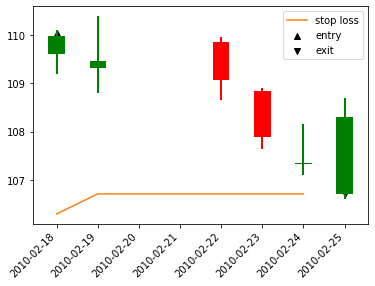

trade 46
entry: [110.38999938964844]
cost_basis: 110.38999938964844
exit: 108.69400100708008
returns: -0.015363695913992372


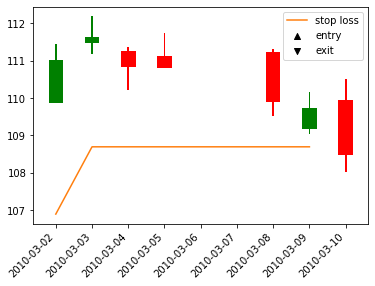

trade 47
entry: [111.3000030517578]
cost_basis: 111.3000030517578
exit: 111.49799804687498
returns: 0.0017789307249624344


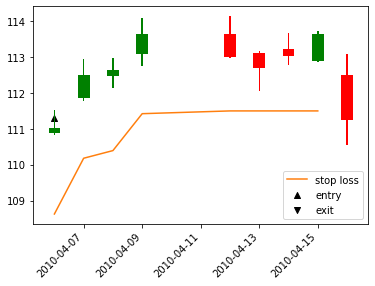

trade 48
entry: [114.12999725341795]
cost_basis: 114.12999725341795
exit: 113.66399765014648
returns: -0.004083059795723551


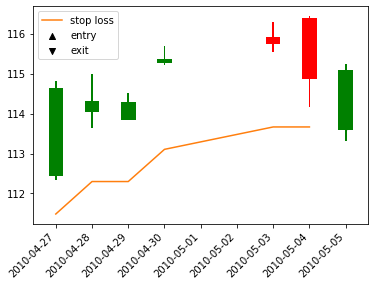

trade 49
entry: [116.43000030517578]
cost_basis: 116.43000030517578
exit: 118.81099700927733
returns: 0.020450027465951173


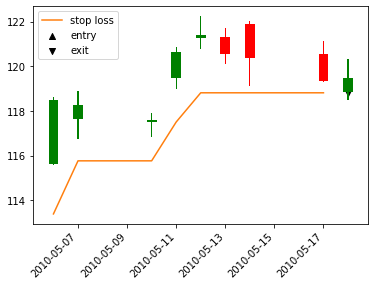

trade 50
entry: [122.23999786376952]
cost_basis: 122.23999786376952
exit: 120.24200210571288
returns: -0.016344860871834278


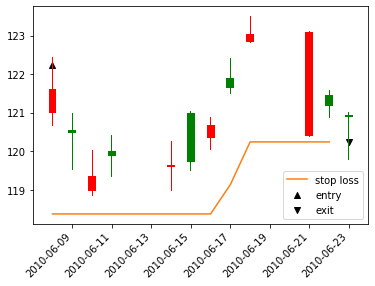

trade 51
entry: [123.5]
cost_basis: 123.5
exit: 119.89900207519531
returns: -0.029157877933641194


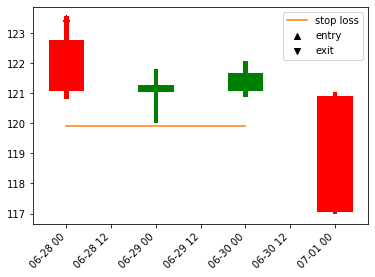

trade 52
entry: [118.6999969482422]
cost_basis: 118.6999969482422
exit: 120.4999969482422
returns: 0.01516428008658557


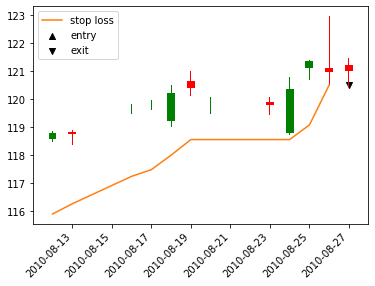

trade 53
entry: [122.9499969482422]
cost_basis: 122.9499969482422
exit: 122.21999740600586
returns: -0.005937369340022411


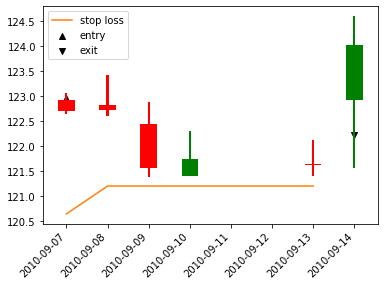

trade 54
entry: [124.58999633789062]
cost_basis: 124.58999633789062
exit: 130.08999938964843
returns: 0.0441448207193271


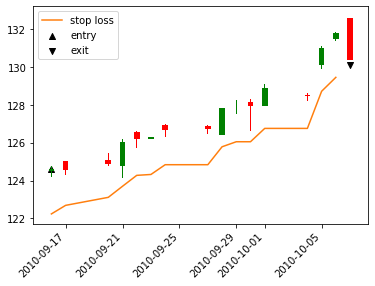

trade 55
entry: [132.6699981689453]
cost_basis: 132.6699981689453
exit: 131.58999633789062
returns: -0.008140512896362492


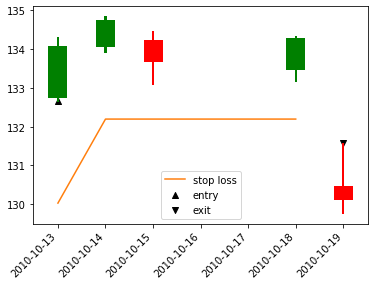

trade 56
entry: [134.85000610351562]
cost_basis: 134.85000610351562
exit: 134.90899353027345
returns: 0.00043742991537236593


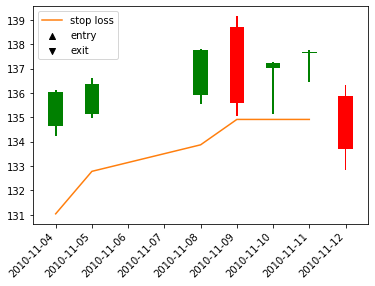

trade 57
entry: [139.14999389648438]
cost_basis: 139.14999389648438
exit: 135.26299438476562
returns: -0.02793388201375236


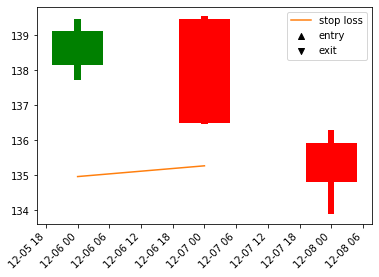

trade 58
entry: [134.39999389648438]
cost_basis: 134.39999389648438
exit: 137.59299926757814
returns: 0.023757481518585723


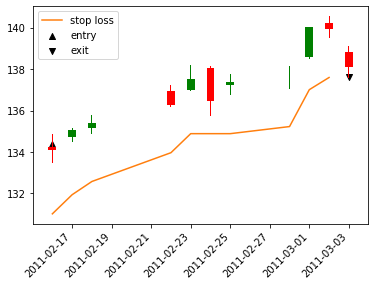

trade 59
entry: [140.5500030517578]
cost_basis: 140.5500030517578
exit: 137.64500122070314
returns: -0.020668813717385003


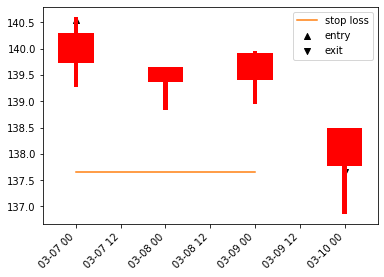

trade 60
entry: [140.61000061035156]
cost_basis: 140.61000061035156
exit: 149.88800048828125
returns: 0.06598392601988688


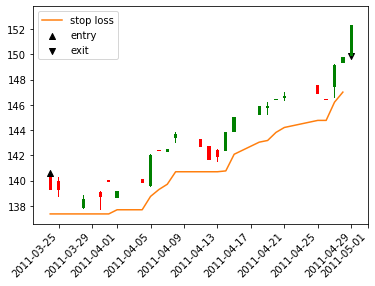

trade 61
entry: [153.02999877929688]
cost_basis: 153.02999877929688
exit: 149.7770004272461
returns: -0.021257259217144248


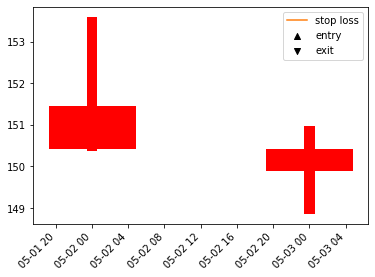

trade 62
entry: [150.97000122070312]
cost_basis: 150.97000122070312
exit: 148.21699981689454
returns: -0.01823542015995594


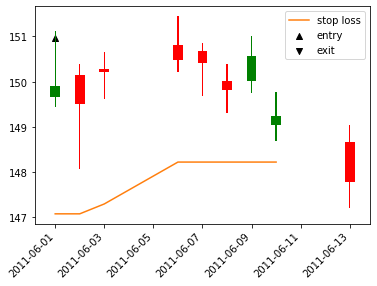

trade 63
entry: [151.4499969482422]
cost_basis: 151.4499969482422
exit: 148.73299713134764
returns: -0.01793991331556826


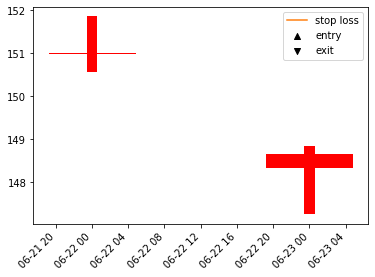

trade 64
entry: [151.86000061035156]
cost_basis: 151.86000061035156
exit: 159.97699432373048
returns: 0.053450504943733164


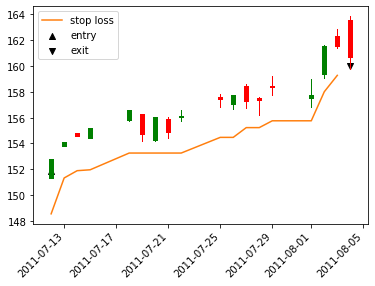

trade 65
entry: [164.75999450683594]
cost_basis: 164.75999450683594
exit: 168.4179946899414
returns: 0.022201992626029652


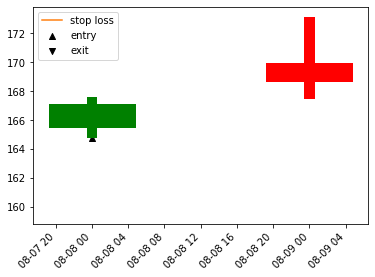

trade 66
entry: [173.14999389648438]
cost_basis: 173.14999389648438
exit: 167.95999450683593
returns: -0.029974008504737384


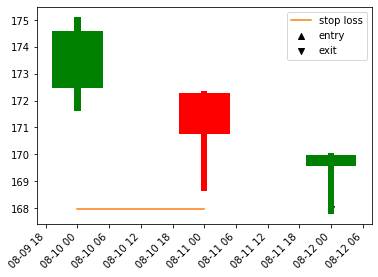

trade 67
entry: [176.41000366210938]
cost_basis: 176.41000366210938
exit: 178.14700622558593
returns: 0.009846394917623583


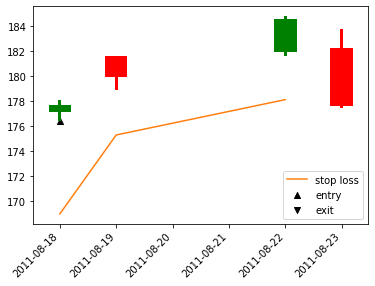

trade 68
entry: [184.82000732421875]
cost_basis: 184.82000732421875
exit: 175.5030059814453
returns: -0.05041121617547161


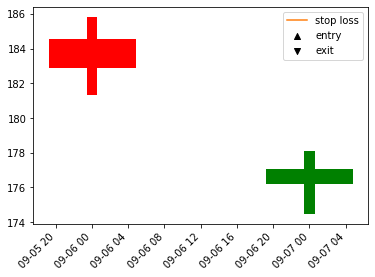

trade 69
entry: [164.16000366210938]
cost_basis: 164.16000366210938
exit: 163.91299591064453
returns: -0.0015046768150253312


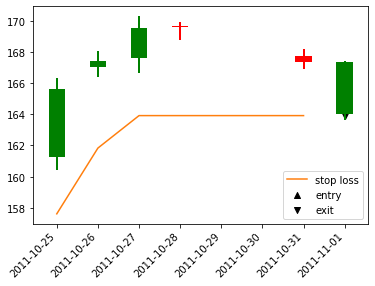

trade 70
entry: [170.2899932861328]
cost_basis: 170.2899932861328
exit: 169.8140106201172
returns: -0.002795129982863095


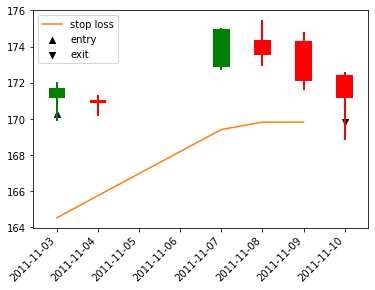

trade 71
entry: [161.6199951171875]
cost_basis: 161.6199951171875
exit: 161.48300018310547
returns: -0.0008476360488854936


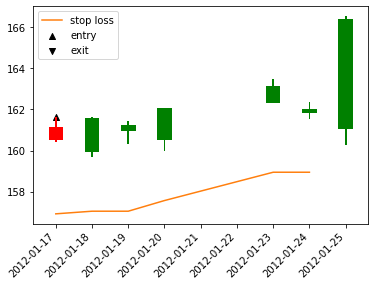

trade 72
entry: [167.0500030517578]
cost_basis: 167.0500030517578
exit: 167.0409957885742
returns: -5.3919563119159955e-05


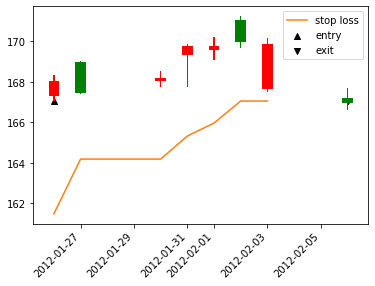

trade 73
entry: [171.22999572753906]
cost_basis: 171.22999572753906
exit: 170.00500030517577
returns: -0.007154093633877698


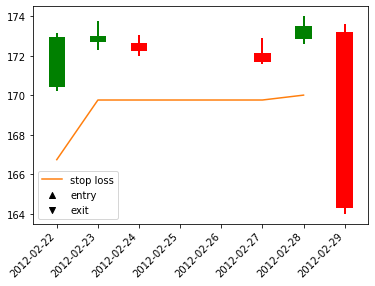

trade 74
entry: [158.30999755859375]
cost_basis: 158.30999755859375
exit: 153.33199768066407
returns: -0.031444633659900204


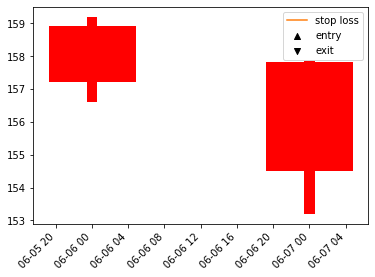

trade 75
entry: [157.72000122070312]
cost_basis: 157.72000122070312
exit: 153.86699523925782
returns: -0.024429406236522025


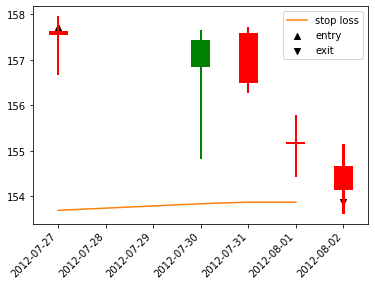

trade 76
entry: [158.69000244140625]
cost_basis: 158.69000244140625
exit: 161.48499603271483
returns: 0.017612915421944045


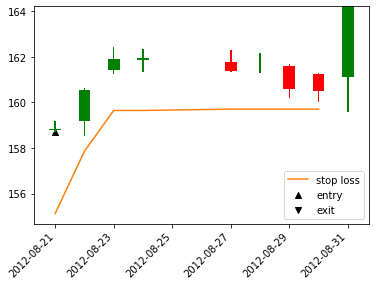

trade 77
entry: [164.22000122070312]
cost_basis: 164.22000122070312
exit: 168.24000091552733
returns: 0.024479354919876888


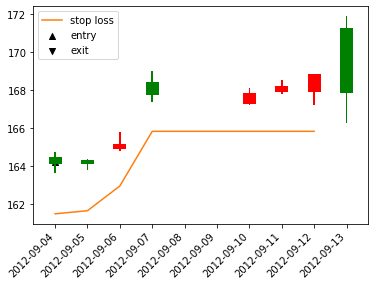

trade 78
entry: [171.91000366210938]
cost_basis: 171.91000366210938
exit: 169.60099029541016
returns: -0.01343152415514809


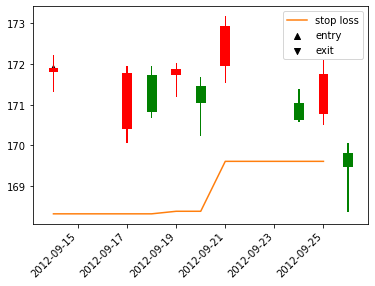

trade 79
entry: [173.17999267578125]
cost_basis: 173.17999267578125
exit: 170.3780044555664
returns: -0.016179630088451254


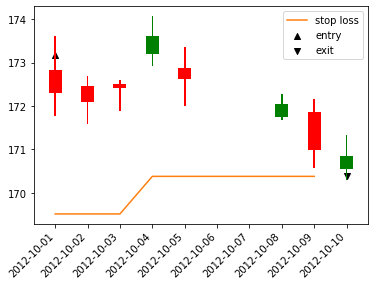

trade 80
entry: [168.5399932861328]
cost_basis: 168.5399932861328
exit: 166.5469940185547
returns: -0.011825082158360893


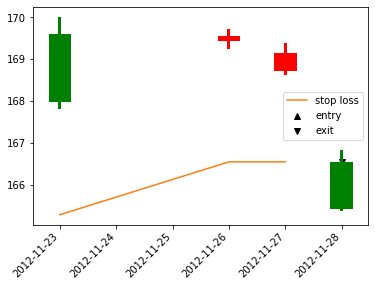

trade 81
entry: [127.58999633789062]
cost_basis: 127.58999633789062
exit: 126.12999725341795
returns: -0.011442896201722768


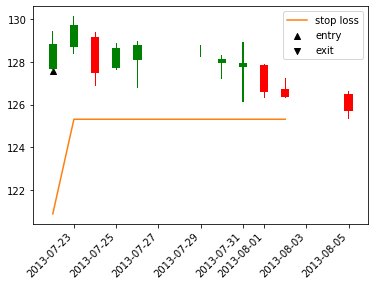

trade 82
entry: [130.13999938964844]
cost_basis: 130.13999938964844
exit: 133.93600158691405
returns: 0.029168604695471886


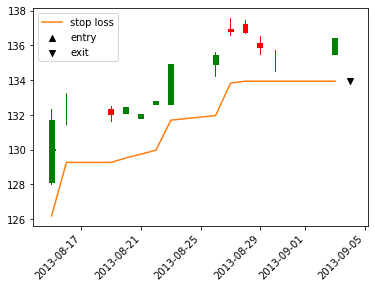

trade 83
entry: [129.5800018310547]
cost_basis: 129.5800018310547
exit: 127.69100570678711
returns: -0.014577836838823596


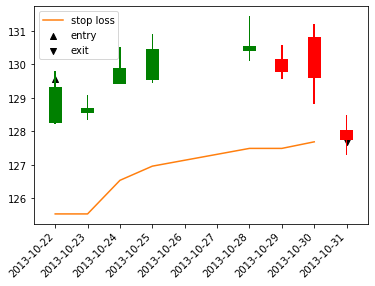

trade 84
entry: [120.7699966430664]
cost_basis: 120.7699966430664
exit: 119.50900039672851
returns: -0.010441303977715165


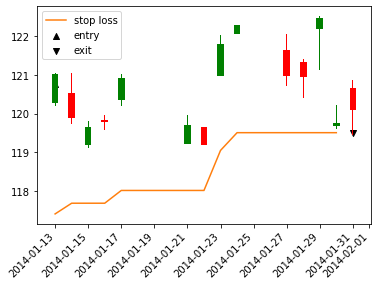

trade 85
entry: [122.72000122070312]
cost_basis: 122.72000122070312
exit: 130.8300048828125
returns: 0.0660854268370166


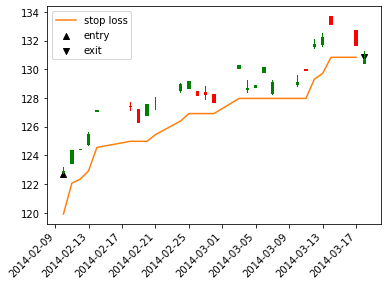

trade 86
entry: [125.23999786376952]
cost_basis: 125.23999786376952
exit: 126.32700729370119
returns: 0.008679411118435737


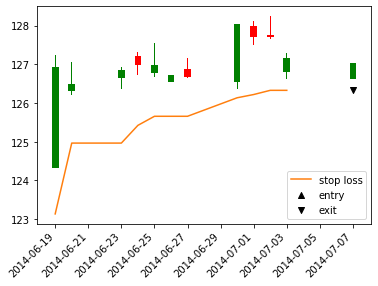

trade 87
entry: [128.24000549316406]
cost_basis: 128.24000549316406
exit: 126.0999984741211
returns: -0.016687515029442535


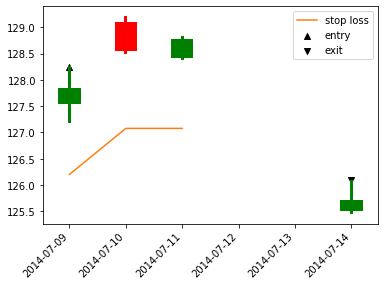

trade 88
entry: [119.23999786376952]
cost_basis: 119.23999786376952
exit: 118.37699890136719
returns: -0.007237495621127879


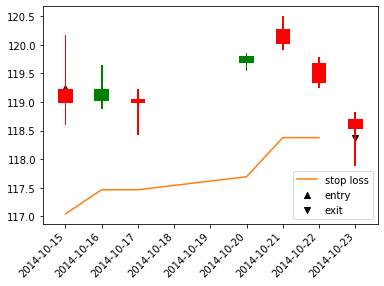

trade 89
entry: [115.95999908447266]
cost_basis: 115.95999908447266
exit: 115.33999862670896
returns: -0.0053466752557668334


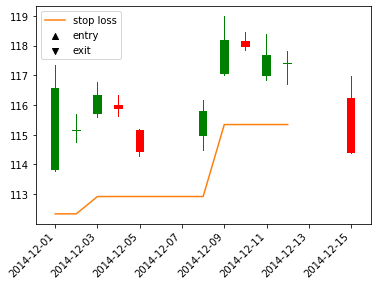

trade 90
entry: [118.37999725341795]
cost_basis: 118.37999725341795
exit: 122.13700332641599
returns: 0.03173683189868095


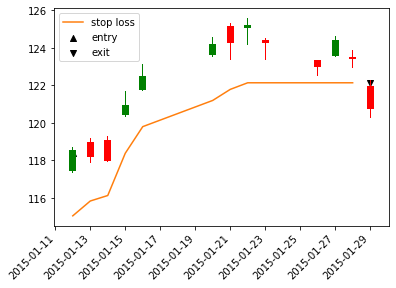

trade 91
entry: [116.5199966430664]
cost_basis: 116.5199966430664
exit: 114.38999938964844
returns: -0.01828010053881782


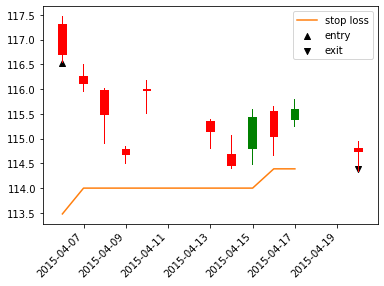

trade 92
entry: [116.62000274658205]
cost_basis: 116.62000274658205
exit: 114.2300033569336
returns: -0.02049390613411299


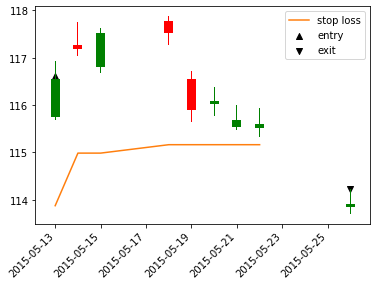

trade 93
entry: [107.91000366210938]
cost_basis: 107.91000366210938
exit: 109.75000228881838
returns: 0.017051233104119393


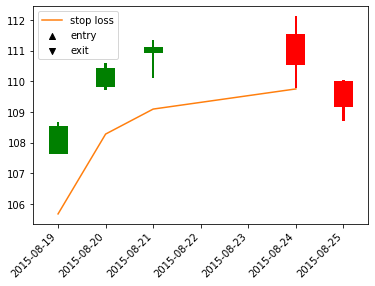

trade 94
entry: [109.7699966430664]
cost_basis: 109.7699966430664
exit: 107.08000183105467
returns: -0.02450573830988311


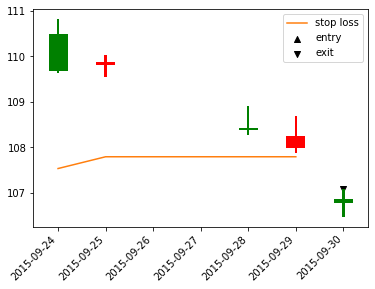

trade 95
entry: [110.81999969482422]
cost_basis: 110.81999969482422
exit: 111.46199874877928
returns: 0.005793169605874357


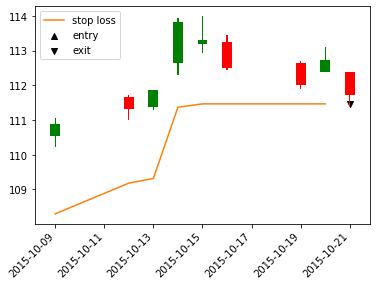

trade 96
entry: [103.93000030517578]
cost_basis: 103.93000030517578
exit: 103.88699645996093
returns: -0.00041377701422669485


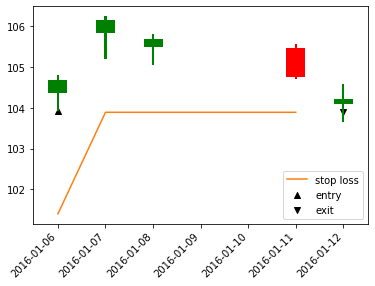

trade 97
entry: [106.26000213623048]
cost_basis: 106.26000213623048
exit: 109.68299942016601
returns: 0.03221341252701163


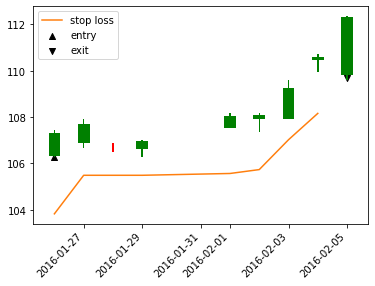

trade 98
entry: [113.38999938964844]
cost_basis: 113.38999938964844
exit: 116.30999755859376
returns: 0.025751813957694564


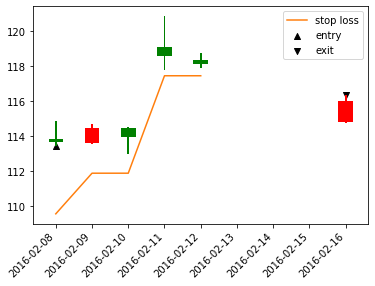

trade 99
entry: [120.83999633789062]
cost_basis: 120.83999633789062
exit: 117.92200241088868
returns: -0.02414758370931014


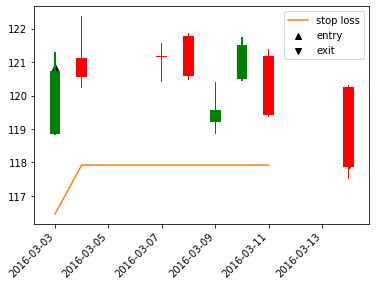

trade 100
entry: [120.3499984741211]
cost_basis: 120.3499984741211
exit: 117.28899841308593
returns: -0.02543415122430074


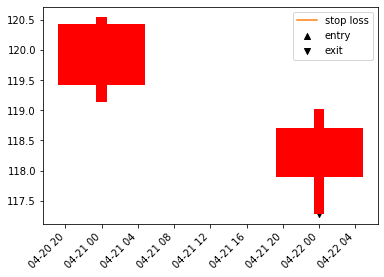

trade 101
entry: [120.5500030517578]
cost_basis: 120.5500030517578
exit: 120.78199844360353
returns: 0.0019244743755512156


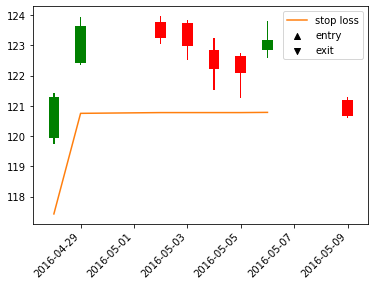

trade 102
entry: [122.97000122070312]
cost_basis: 122.97000122070312
exit: 123.05599822998047
returns: 0.0006993332391938778


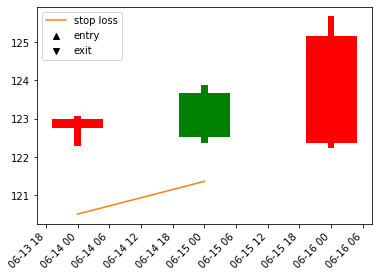

trade 103
entry: [125.66999816894533]
cost_basis: 125.66999816894533
exit: 127.62799530029295
returns: 0.01558046598135044


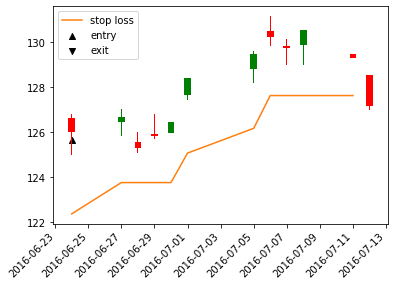

trade 104
entry: [123.18000030517578]
cost_basis: 123.18000030517578
exit: 122.69500045776367
returns: -0.003937326239734824


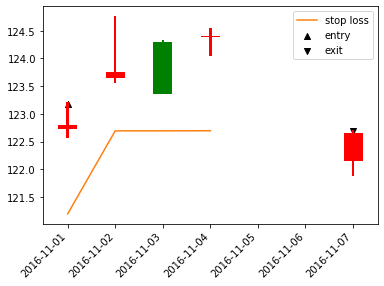

trade 105
entry: [112.5]
cost_basis: 112.5
exit: 113.74799804687501
returns: 0.011093315972222323


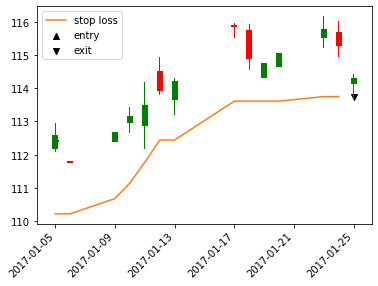

trade 106
entry: [116.16999816894533]
cost_basis: 116.16999816894533
exit: 118.10299987792969
returns: 0.016639422737815754


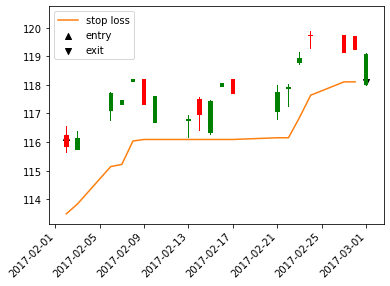

trade 107
entry: [120.08000183105467]
cost_basis: 120.08000183105467
exit: 121.20399780273438
returns: 0.009360392692707477


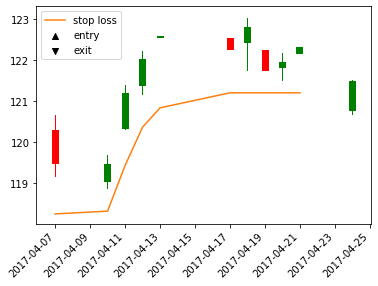

trade 108
entry: [120.7699966430664]
cost_basis: 120.7699966430664
exit: 121.41499786376956
returns: 0.0053407405699400674


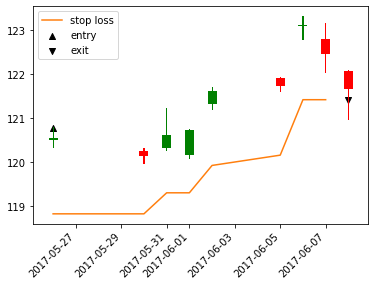

trade 109
entry: [119.58000183105467]
cost_basis: 119.58000183105467
exit: 119.45599975585937
returns: -0.0010369800409478146


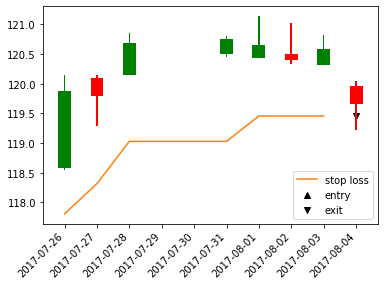

trade 110
entry: [121.13999938964844]
cost_basis: 121.13999938964844
exit: 121.0740005493164
returns: -0.0005448146001698123


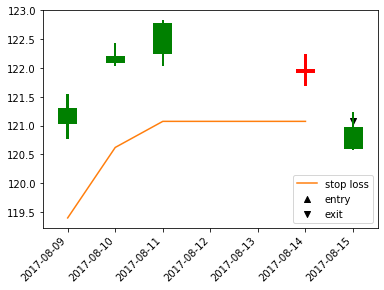

trade 111
entry: [122.83000183105467]
cost_basis: 122.83000183105467
exit: 125.99700241088865
returns: 0.02578360769048918


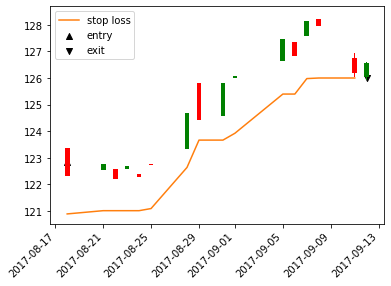

trade 112
entry: [122.41000366210938]
cost_basis: 122.41000366210938
exit: 121.30800094604491
returns: -0.009002554391766381


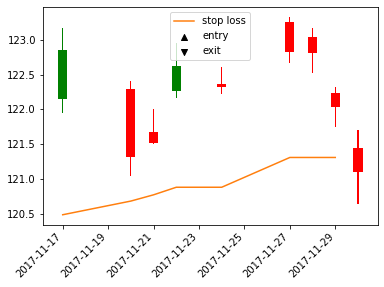

trade 113
entry: [122.55999755859376]
cost_basis: 122.55999755859376
exit: 127.45399703979491
returns: 0.039931458703411075


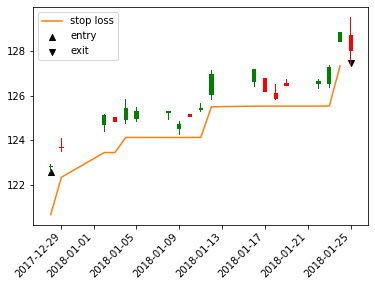

trade 114
entry: [127.61000061035156]
cost_basis: 127.61000061035156
exit: 126.39099960327148
returns: -0.009552550750330433


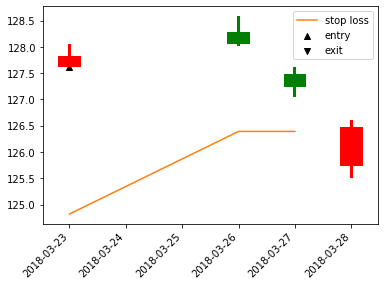

trade 115
entry: [128.5800018310547]
cost_basis: 128.5800018310547
exit: 125.76000213623048
returns: -0.021931868522832118


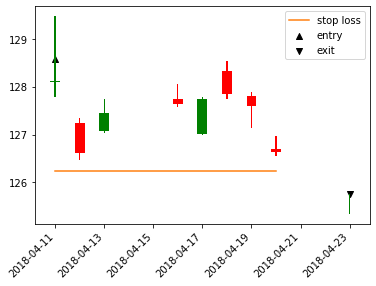

trade 116
entry: [123.81999969482422]
cost_basis: 123.81999969482422
exit: 122.1999969482422
returns: -0.013083530532828248


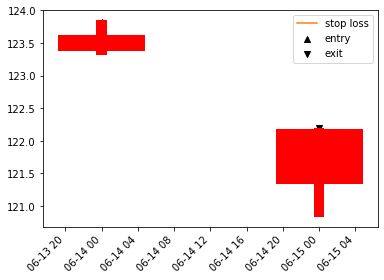

trade 117
entry: [114.77999877929688]
cost_basis: 114.77999877929688
exit: 115.16999816894533
returns: 0.003397799214115315


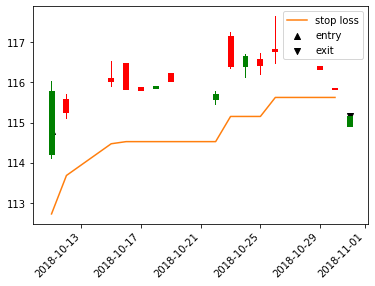

trade 118
entry: [116.93000030517578]
cost_basis: 116.93000030517578
exit: 121.0199966430664
returns: 0.034978160670624626


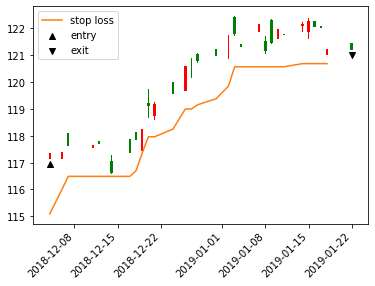

trade 119
entry: [122.45999908447266]
cost_basis: 122.45999908447266
exit: 123.56400299072266
returns: 0.009015220598592855


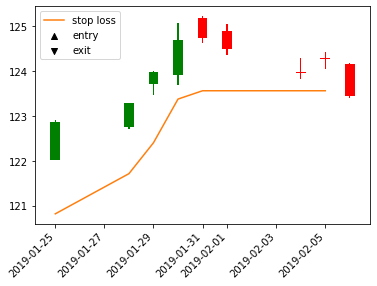

trade 120
entry: [125.93000030517578]
cost_basis: 125.93000030517578
exit: 125.4749984741211
returns: -0.0036131329306126167


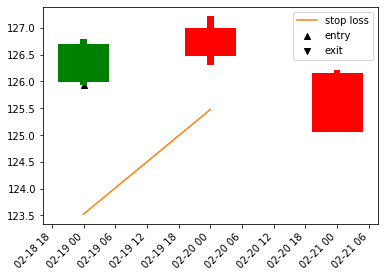

trade 121
entry: [122.33000183105467]
cost_basis: 122.33000183105467
exit: 121.3169952392578
returns: -0.008280933349415718


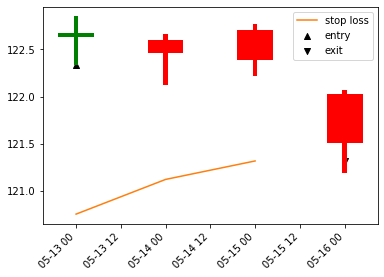

trade 122
entry: [122.8499984741211]
cost_basis: 122.8499984741211
exit: 125.3590019226074
returns: 0.02042330874765818


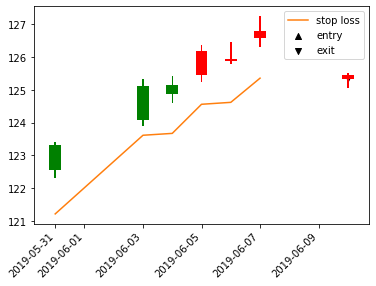

trade 123
entry: [127.25]
cost_basis: 127.25
exit: 132.8280059814453
returns: 0.04383501753591592


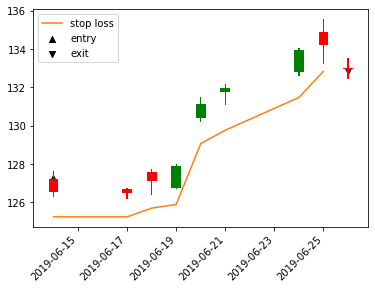

trade 124
entry: [135.5500030517578]
cost_basis: 135.5500030517578
exit: 133.11599578857422
returns: -0.017956526804755568


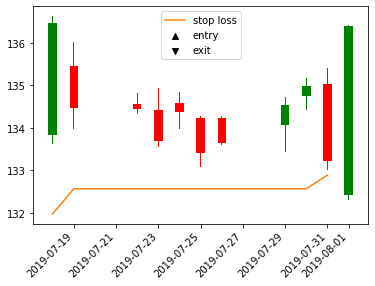

trade 125
entry: [137.0500030517578]
cost_basis: 137.0500030517578
exit: 139.7270080566406
returns: 0.019533053230738076


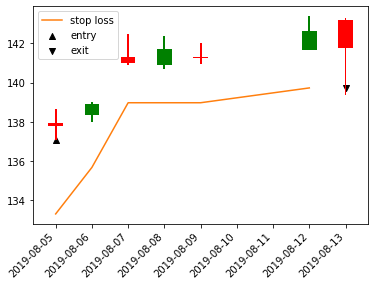

trade 126
entry: [143.3800048828125]
cost_basis: 143.3800048828125
exit: 143.17201080322266
returns: -0.0014506491317240224


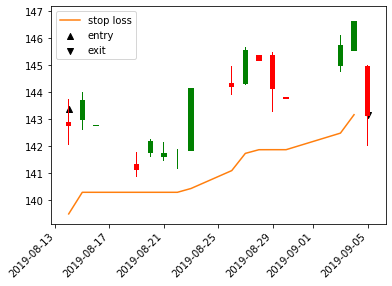

trade 127
entry: [142.8300018310547]
cost_basis: 142.8300018310547
exit: 140.49700469970702
returns: -0.016334083185878794


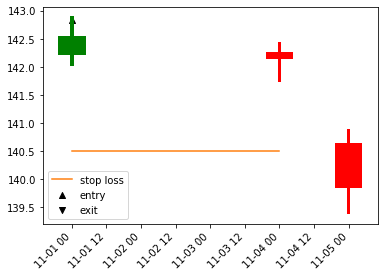

trade 128
entry: [139.57000732421875]
cost_basis: 139.57000732421875
exit: 146.35799560546874
returns: 0.0486350069860039


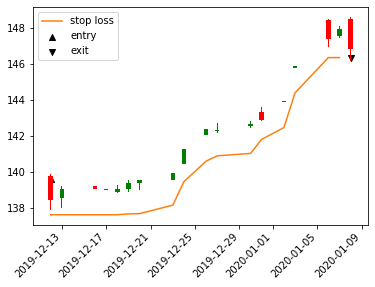

trade 129
entry: [148.61000061035156]
cost_basis: 148.61000061035156
exit: 147.02999877929688
returns: -0.010631867468982642


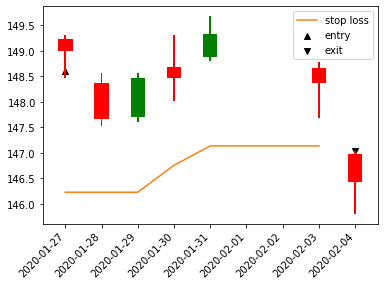

trade 130
entry: [149.67999267578125]
cost_basis: 149.67999267578125
exit: 155.72899627685547
returns: 0.04041290684839116


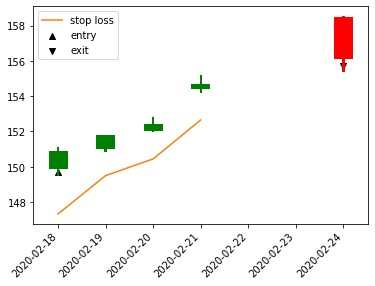

trade 131
entry: [158.52999877929688]
cost_basis: 158.52999877929688
exit: 154.2929931640625
returns: -0.026726838124392326


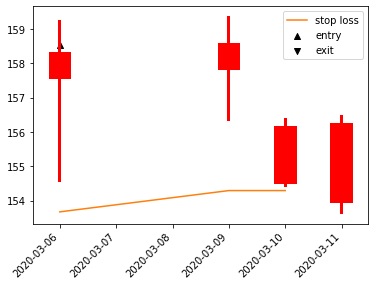

trade 132
entry: [157.22000122070312]
cost_basis: 157.22000122070312
exit: 158.06800537109376
returns: 0.005393742168976456


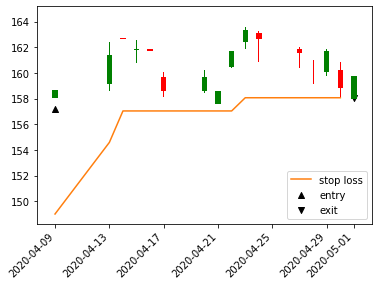

trade 133
entry: [163.60000610351562]
cost_basis: 163.60000610351562
exit: 160.79900512695312
returns: -0.017121032225330186


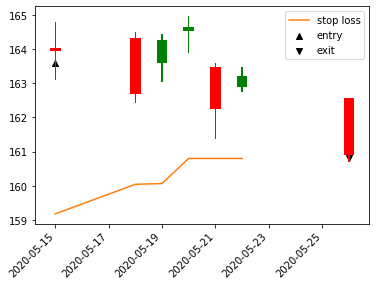

trade 134
entry: [164.0800018310547]
cost_basis: 164.0800018310547
exit: 182.1779983520508
returns: 0.11029983129589885


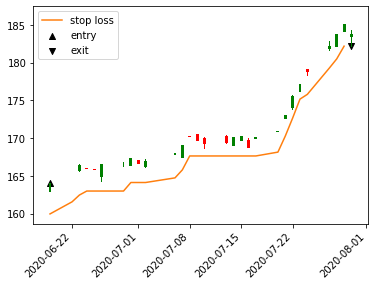

trade 135
entry: [186.13999938964844]
cost_basis: 186.13999938964844
exit: 189.68499450683595
returns: 0.019044778816006885


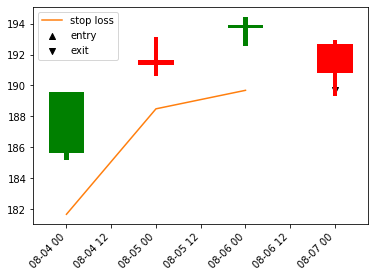

trade 136
entry: [181.1699981689453]
cost_basis: 181.1699981689453
exit: 176.85000610351562
returns: -0.02384496389629144


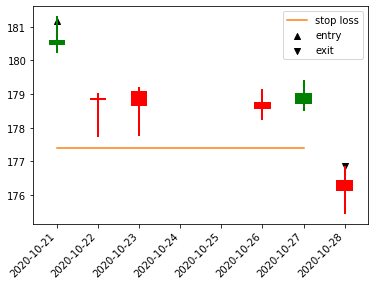

trade 137
entry: [181.30999755859372]
cost_basis: 181.30999755859372
exit: 176.4499969482422
returns: -0.0268049234779838


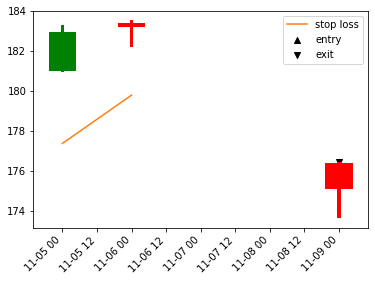

trade 138
entry: [176.86000061035156]
cost_basis: 176.86000061035156
exit: 179.33501129150392
returns: 0.013994179987622897


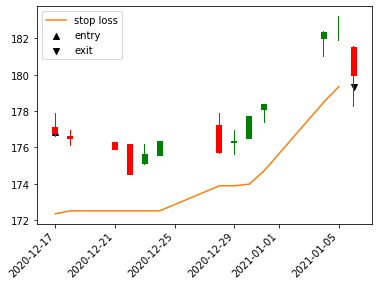

trade 139
entry: [164.14999389648438]
cost_basis: 164.14999389648438
exit: 164.90400238037108
returns: 0.00459341158649203


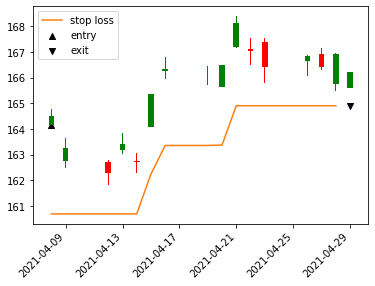

trade 140
entry: [168.38999938964844]
cost_basis: 168.38999938964844
exit: 175.62999877929687
returns: 0.042995423813116905


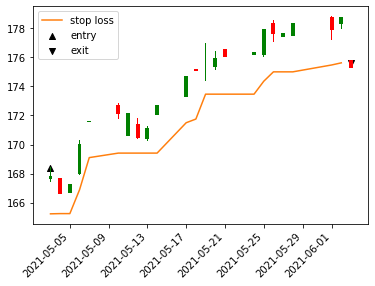

trade 141
entry: [171.3000030517578]
cost_basis: 171.3000030517578
exit: 168.5929916381836
returns: -0.015802751694968108


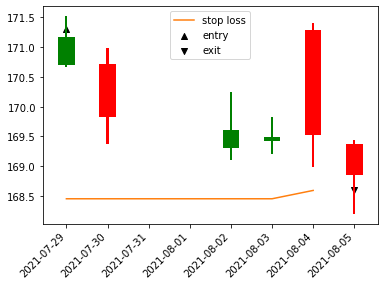

trade 142
entry: [170.19000244140625]
cost_basis: 170.19000244140625
exit: 166.99100036621093
returns: -0.018796650974235045


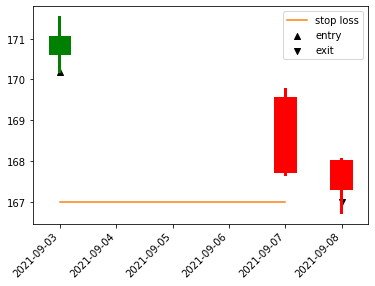

trade 143
entry: [167.9199981689453]
cost_basis: 167.9199981689453
exit: 166.1189956665039
returns: -0.010725360422106525


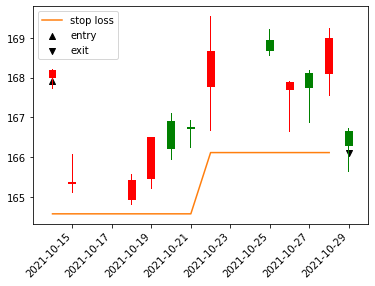

trade 144
entry: [169.5399932861328]
cost_basis: 169.5399932861328
exit: 170.44000244140625
returns: 0.0053085359851022945


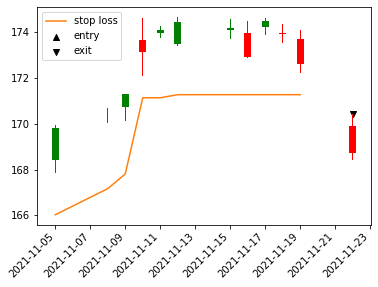

trade 145
entry: [169.1300048828125]
cost_basis: 169.1300048828125
exit: 168.47199401855468
returns: -0.0038905625569735157


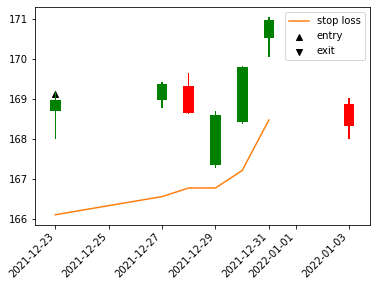

trade 146
entry: [171.0399932861328]
cost_basis: 171.0399932861328
exit: 170.15499420166014
returns: -0.0051742231010974875


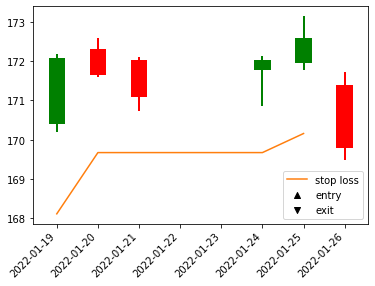

trade 147
entry: [173.14999389648438]
cost_basis: 173.14999389648438
exit: 178.96300506591794
returns: 0.03357211304846365


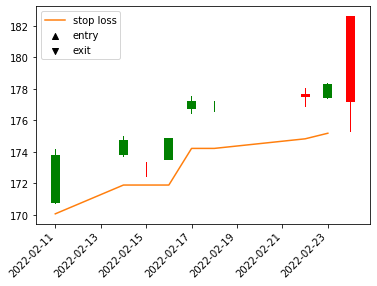

trade 148
entry: [182.6000061035156]
cost_basis: 182.6000061035156
exit: 188.2780014038086
returns: 0.031095263474822374


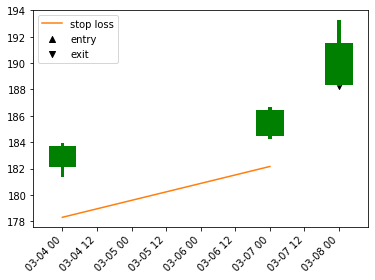

trade 149
entry: [183.50999450683597]
cost_basis: 183.50999450683597
exit: 182.1920059204101
returns: -0.007182107928060335


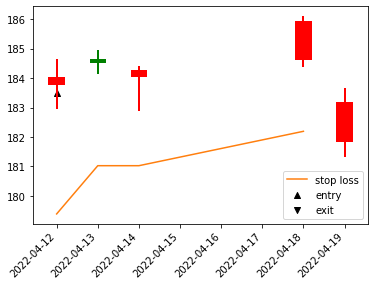

trade 150
entry: [174.4499969482422]
cost_basis: 174.4499969482422
exit: 170.88499145507814
returns: -0.020435686761414835


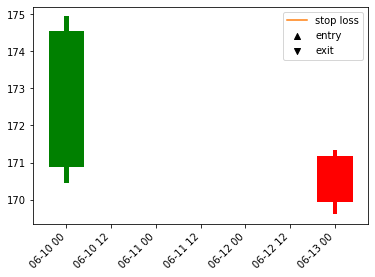

trade 151
entry: [166.4600067138672]
cost_basis: 166.4600067138672
exit: 164.6269973754883
returns: -0.011011710107219401


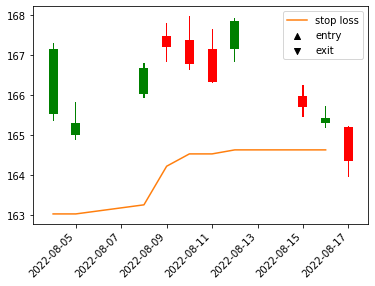

trade 152
entry: [156.80999755859375]
cost_basis: 156.80999755859375
exit: 161.96299438476564
returns: 0.0328614049257058


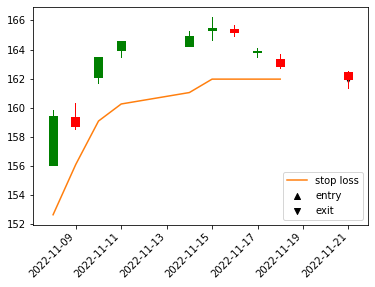

trade 153
entry: [166.97999572753906]
cost_basis: 166.97999572753906
exit: 166.2100067138672
returns: -0.004611265021998591


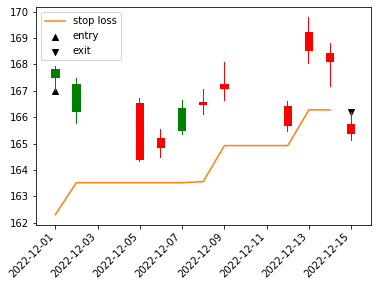

trade 154
entry: [169.7899932861328]
cost_basis: 169.7899932861328
exit: 177.82499542236326
returns: 0.04732317836122257


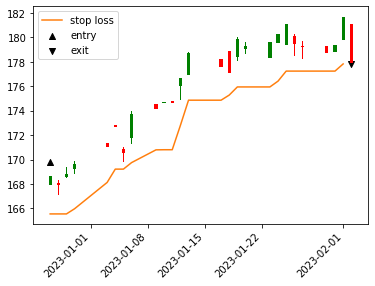

trade 155
entry: [176.3000030517578]
cost_basis: 176.3000030517578
exit: 180.63199615478513
returns: 0.02457171314827225


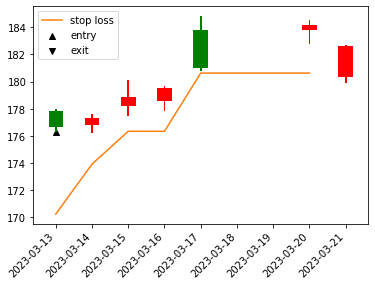

trade 156
entry: [184.80999755859372]
cost_basis: 184.80999755859372
exit: 181.04900512695315
returns: -0.020350589693872795


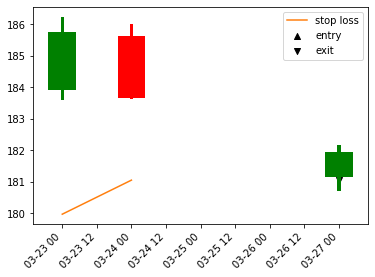

trade 157
entry: [186.2400054931641]
cost_basis: 186.2400054931641
exit: 185.40700531005857
returns: -0.00447272421894393


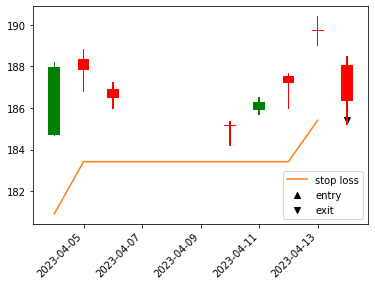

trade 158
entry: [190.41000366210935]
cost_basis: 190.41000366210935
exit: 185.88700256347653
returns: -0.02375400982954171


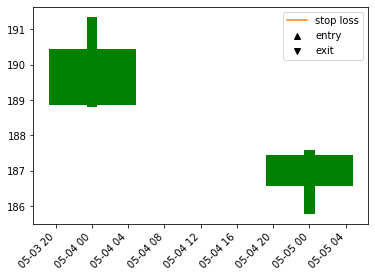

In [8]:
tl.plot_all_trades()

We can plot the trades that occur over a specific period of time to see how this strategy perform.

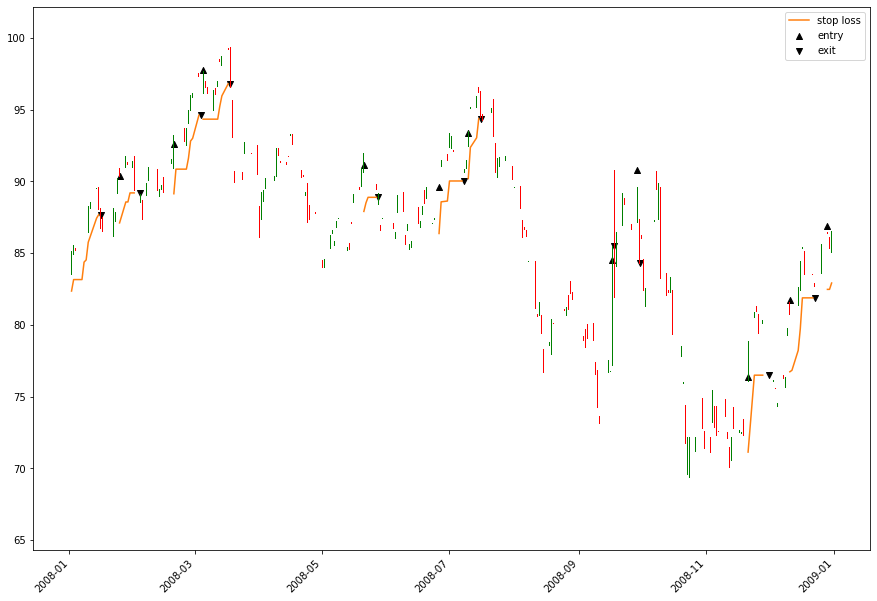

In [9]:

start_datetime= pd.to_datetime(dt.date(2008, 1, 1))
end_datetime = pd.to_datetime(dt.date(2009, 1, 1))

tl.plot_time_period(df, start_datetime, end_datetime)

We note that the time in trade for winning trades is generally higher than that of losing trades.

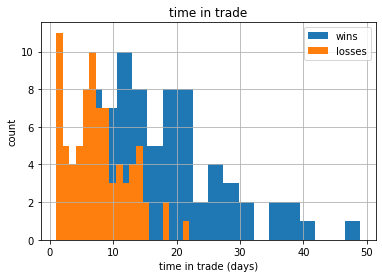

In [10]:
tl.win_records['time_in_trade'].hist(bins=20, label='wins')
tl.loss_records['time_in_trade'].hist(bins=20, label='losses')
plt.xlabel('time in trade (days)')
plt.ylabel('count')
plt.title('time in trade')
plt.legend()
plt.show()

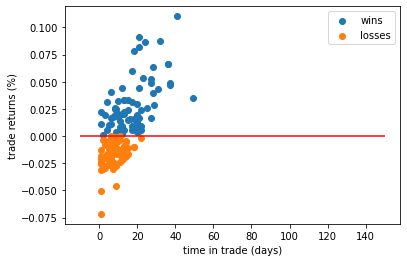

In [11]:
plt.scatter(tl.win_records['time_in_trade'], tl.win_records['returns'], label='wins')
plt.scatter(tl.loss_records['time_in_trade'], tl.loss_records['returns'], label='losses')
plt.hlines(0, -10, 150, color='red')
plt.legend()
plt.xlabel('time in trade (days)')
plt.ylabel('trade returns (%)')
plt.show()

### Analysis

We note that the turtle trading rules follow a trend-following or momentum trading strategy. The characteristic of these strategies is greater volatility, with lower win-rate but higher returns per winning trade.

Ideally, the strategy goes long when a long-term upward trend is established and follows the trend until it is exhausted, while avoiding big drawdowns when long-term downward trends are established. 

The downside to this strategy is that short-term volatility is likely to cause whipsaw losses. An example of this is losses when the underlying is trading within a range.

Therefore, the way to optimise this strategy is to pick the underlying prone to more frequent long-term trends with greater magnitude compared to short-term volatility. It does not matter which direction that long-term trend is in since we can just inverse the rules, e.g. go short when price breaks out under the 20-day low. This is also possibly why the original turtle traders focused on commodity trading, since commodities tend to exhibit trends based on the physical demand and supply of the commodity, whereas equities may be more volatile in the short-term due to speculation.

Another key part to the success of this strategy is to trade diversified and uncorrelated assets so that the various assets will be trending at different times. This will go a long way towards reducing the volatility of a portfolio trading all of these assets.

Another idea is to trade this strategy on leveraged ETFs, for example UPRO (3 x leveraged SP500) instead of trading on SPY. The nature of the ETF (3 x daily returns) is likely to cause the magnitude of long-term trends to increase significantly, thus increasing the returns per winning trade of this strategy. The volatility drag of the leverage should also reduce the number of whipsaw losing trades. Therefore, the overall profitability of this strategy on leveraged ETFs should increase. More testing is required however, since we have to account for a higher expense ratio, tracking error, and a lack of historical data since these ETFs are a relatively recent invention.